# Image Classification

## Preparation


### Prequisite Installation

In [1]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 113.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 29.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.6
    Uninstalling protobuf-4.25.6:
      Successfully uninstalled protobuf-4.25.6
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2


### Import requirement

In [2]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflowjs as tfjs
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import io
import seaborn as sns
from PIL import Image

# System libraries
from pathlib import Path
import os.path

# Metrics
sns.set_style('darkgrid')

# Kaggle Dataset
import kagglehub

In [3]:
tf.version.VERSION

'2.18.0'

### Data Scraping and Preparation

- Data will be pulled from Google Scrapped Image Set. <ref> https://www.kaggle.com/datasets/duttadebadri/image-classification/code </ref>
- Data classes are 4 and will be cleaned before use as seen below. folder name has lot of typo
- for simplification the classname used will be first word of the classes
- Data for training and validation will be splitted from main images sub directory where it has around 32k image
- Validation sub directory will be used for testing with 122 images count

In [4]:
%run ./scraping.ipynb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10246  100 10246    0     0  21150      0 --:--:-- --:--:-- --:--:-- 21169


100%|██████████| 2.34G/2.34G [01:55<00:00, 21.7MB/s]

Extracting files...


Path to dataset files: ./dataset/datasets/duttadebadri/image-classification/versions/2
There are 3 directories and 0 images in './dataset/datasets/duttadebadri/image-classification/versions/2'.
There are 1 directories and 0 images in './dataset/datasets/duttadebadri/image-classification/versions/2/test'.
There are 1 directories and 0 images in './dataset/datasets/duttadebadri/image-classification/versions/2/test/test'.
There are 0 directories and 10 images in './dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify'.
There are 1 directories and 0 images in './dataset/datasets/duttadebadri/image-classification/versions/2/validation'.
There are 4 directories and 0 images in './dataset/datasets/duttadebadri/image-classification/versions/2/validation/validation'.
There are 0 directories and 37 images in './dataset/datasets/duttadebadri/image-classification/versions/2/validation/validation/architecture'.
There are 0 directories and 30 images in './dataset/datasets

In [5]:
path = r"/content/dataset/datasets/duttadebadri/image-classification/versions/2"

train_dir = path + r"/images/images"
val_dir = path + r"/validation/validation"

Found 35093 files belonging to 4 classes.
Using 28075 files for training.
Train Classes: ['architecture', 'art', 'food', 'travel']
Training Dataset Size: 28075
Found 35093 files belonging to 4 classes.
Using 7018 files for validation.
Validation Classes: ['architecture', 'art', 'food', 'travel']
Validation Dataset Size: 7018
Found 122 files belonging to 4 classes.
Test Classes: ['architecture', 'art', 'food', 'travel']
Test Dataset Size: 122


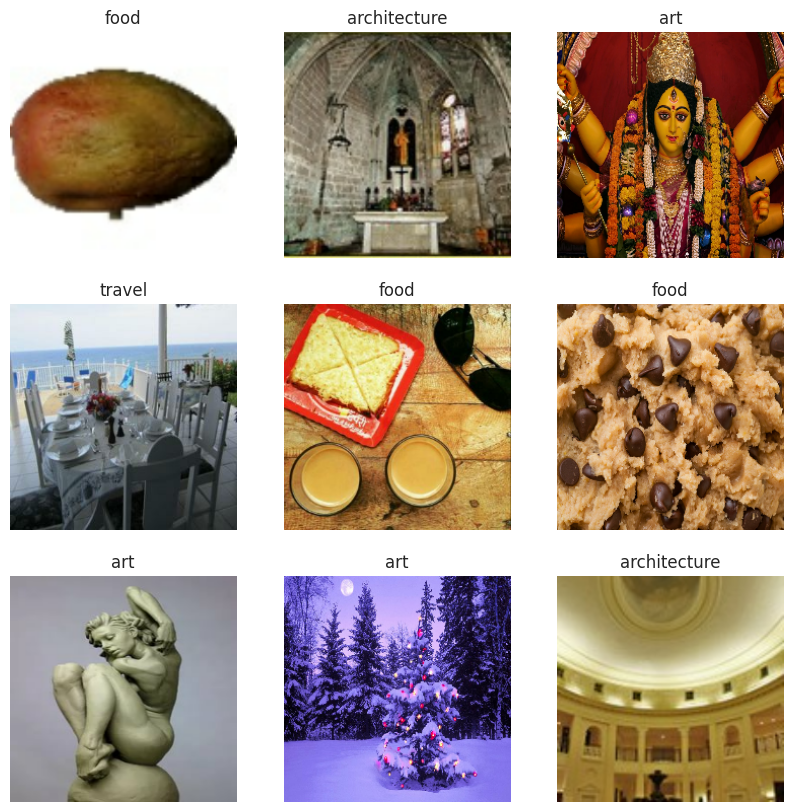

In [6]:
IMAGE_SIZE = (224, 224)  # Fix image size format
BATCH_SIZE = 32

# Load datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)
train_class_names = train_dataset.class_names
print(f"Train Classes: {train_class_names}")
print(f"Training Dataset Size: {len(train_dataset.file_paths)}")
print("==============================================================")
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)

val_class_names = val_dataset.class_names
print(f"Validation Classes: {val_class_names}")

print(f"Validation Dataset Size: {len(val_dataset.file_paths)}")
print("==============================================================")

test_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=42
)

test_class_names = test_dataset.class_names
print(f"Test Classes: {test_class_names}")
print(f"Test Dataset Size: {len(test_dataset.file_paths)}")
print("==============================================================")

class_length = len(train_class_names)

# Display sample images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[labels[i].numpy()])
        plt.axis("off")
plt.show()

In [7]:
def encode_dataset(dataset):
  return dataset.map(lambda x, y: (
      x,
      tf.one_hot(y, depth=class_length)
  ))

In [8]:
train_data = encode_dataset(train_dataset)
val_data = encode_dataset(val_dataset)

for images, labels in train_data.take(1):
    print("Image batch shape:", images.shape)
    print("Labels batch shape:", labels.shape)
    print("Sample label:", labels[0].numpy())

Image batch shape: (32, 224, 224, 3)
Labels batch shape: (32, 4)
Sample label: [0. 0. 0. 1.]


In [9]:
# Prefetching data

AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

print(train_data)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>


## Training

### Training Preparation

- Creating custom callback where training will be stopped if accuracy and validation accuracy is above 95%
- Creating Callback Builder to create required callbacks
- Creating Plot History to plot history into graph

In [10]:
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        acc = logs.get('accuracy')
        val_acc = logs.get("val_accuracy")

        if acc > 0.95 and val_acc > 0.95:
            print(f"Stopping training at accuracy: {acc} val_accuracy: {val_acc}")
            self.model.stop_training = True

In [11]:
def build_callbacks(
    factor=0.1,
    patience=4,
    filepath=None,
    custom_callback=CustomCallback(),
):
    callbacks = []
    callbacks.append(custom_callback)

    lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=factor,
        patience=patience,
        verbose=2,
        mode="min"
    )
    callbacks.append(lr_callback)

    if not filepath:
        return callbacks

    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_accuracy',
        verbose=2,
        save_best_only=True,
    )

    callbacks.append(checkpoint_callback)

    return callbacks

In [12]:
def plot_history(history, model_name="Model"):
  model_acc = history.history['accuracy']
  model_val_acc = history.history['val_accuracy']

  model_loss = history.history['loss']
  model_val_loss = history.history['val_loss']

  epoch_range = range(len(model_acc))

  plt.figure(figsize = (12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_range, model_acc, label='Training Accuracy')
  plt.plot(epoch_range, model_val_acc, label='Validation Accuracy')
  plt.title(f'Training and Validation Accuracy {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')

  plt.subplot(1, 2, 2)
  plt.plot(epoch_range, model_loss, label='Training Loss')
  plt.plot(epoch_range, model_val_loss, label='Validation Loss')
  plt.title(f'Training and Validation Loss {model_name}')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(loc='upper right')

  plt.show()

In [13]:
def train_model(model, train_data, val_data, epochs=10, steps=None, callbacks=None):
    print(f"start training with callbacks: {callbacks}")
    return model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=callbacks,
        steps_per_epoch=steps
    )

### Model building
- Base for transfer model used is MobileNetV3Large
>
- Model is using Sequential API and divided into 6 parts:
> - 1. Input Layer - Data input
> - 2. Augmentation Layer - Data Augmentation. e.g: rescale, flip and rotation
> - 3. Pretrained Layer - Pretrained Model layer
> - 4. Requirement Layer - Dicoding CNN required layer
> - 5. Additional Layer - Dense Layer for connecting CNN into output
> - 6. Output Layer - Converting Predicted output into Class Length
>
- Consideration for picking this model is:
> - 1. model is pretty small and simple
> - 2. premade model preprocessing can be opted out
> - 3. required layer is actually improving the model performance and not hindering it (atop of simple model added pretty complex layer can save the model performance)
> - 4. training is faster and inference even more with pretty limited resource

In [14]:
from tensorflow.keras.applications import MobileNetV3Large, EfficientNetB0, ResNet50V2, VGG19
# Initialize ResNet model and freeze it
input_shape = (224, 224, 3)
MODEL_NAME="MobNetTransfer"

BaseModel = MobileNetV3Large(
    weights="imagenet",
    include_top=False,
    include_preprocessing=False # use this on mobilenet
)
BaseModel.trainable = False

# Create the sequential model with input shape
transfer_model = tf.keras.Sequential([
    # == Input Layer == #
    tf.keras.layers.Input(shape=input_shape),
    # == Input Layer == #

    # == Augmentation Layer == #
    tf.keras.layers.Rescaling(1./127.5, offset=-1),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    # tf.keras.layers.RandomZoom(0.2),
    # tf.keras.layers.RandomTranslation(0.2, 0.2),
    # == Augmentation Layer == #

    # == Pretrained Layer == #
    BaseModel,
    # == Pretrained Layer == #

    # == Requirement Layer == #
    tf.keras.layers.Conv2D(512, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('swish'),
    tf.keras.layers.SpatialDropout2D(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    # == Requirement Layer == #

    # == Additional Layer == #
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('swish'),
    tf.keras.layers.Dropout(0.2),
    # == Additional Layer == #

    # == Output Layer == #
    tf.keras.layers.Dense(class_length, activation='softmax')
    # == Output Layer == #
], name=MODEL_NAME)

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4)
transfer_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=[
        'accuracy',
        'f1_score'
    ]
)

transfer_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "MobNetTransfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 512)           │       4,424,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 5, 5, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_20 (Activation)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_21 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,475,780 (32.33 MB)

 Trainable params: 5,477,380 (20.89 MB)

 Non-trainable params: 2,998,400 (11.44 MB)

In [15]:
BaseModel.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, None, None, 16) │            432 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, None, None, 16) │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 16) │              0 │ conv_bn[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, None, None, 16) │            144 │ activation[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, None, None, 16) │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, None, None, 16) │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, None, None, 16) │            256 │ re_lu[0][0]            │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, None, None, 16) │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, None, None, 16) │              0 │ activation[0][0],      │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, None, None, 64) │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, None, None, 64) │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, None, None, 64) │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwis… │ (None, None, None, 64) │              0 │ re_lu_1[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depthwise │ (None, None, None, 64) │            576 │ expanded_conv_1_depth… │
│ (DepthwiseConv2D)    

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

### Model Training
 - Max Epochs is 20
 - FILEPATH constant to define saved model filename and path
 - patience parameter for Reduced Learning Rate callback patience

In [16]:
EPOCHS=20
FILEPATH="mobnet-transfer.keras"

callbacks = build_callbacks(
    filepath=FILEPATH,
    patience=2
)

transfer_history = train_model(
    transfer_model,
    train_data,
    val_data,
    epochs=EPOCHS,
    callbacks=callbacks,
)

start training with callbacks: [<__main__.CustomCallback object at 0x7fb99b5a16d0>, <keras.src.callbacks.reduce_lr_on_plateau.ReduceLROnPlateau object at 0x7fb95c6768d0>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fb99d625150>]
Epoch 1/20
878/878 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8352 - f1_score: 0.8352 - loss: 0.4515
Epoch 1: val_accuracy improved from -inf to 0.92833, saving model to mobnet-transfer.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 60s 54ms/step - accuracy: 0.8352 - f1_score: 0.8352 - loss: 0.4513 - val_accuracy: 0.9283 - val_f1_score: 0.9280 - val_loss: 0.2159 - learning_rate: 1.0000e-04
Epoch 2/20
876/878 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9227 - f1_score: 0.9226 - loss: 0.2300
Epoch 2: val_accuracy improved from 0.92833 to 0.94001, saving model to mobnet-transfer.keras
878/878 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.9228 - f1_score: 0.9226 - loss: 0.2300 - val_accuracy: 0.9400 - val_f1_score: 0.9397 - val_loss: 0.1829 -

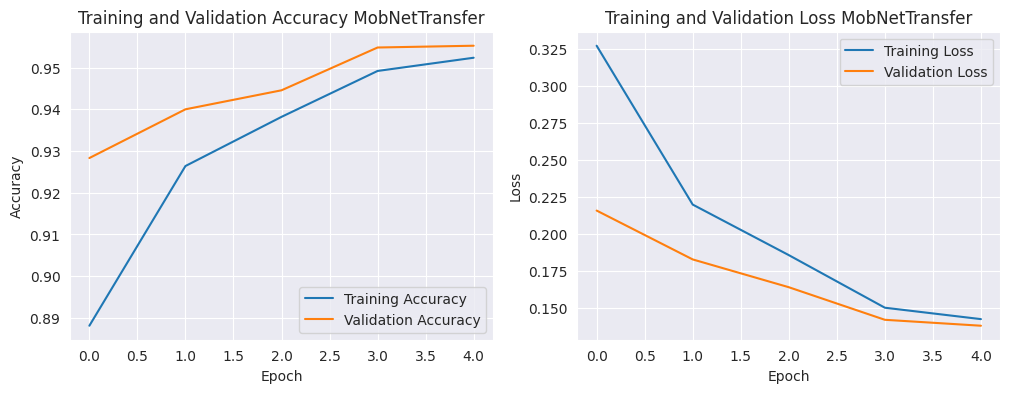

In [17]:
# Plotting ResNet model
plot_history(transfer_history, transfer_model.name)

## Inference

### Validation Inference

- data is from valdidation sub directory
- model used is from saved best model from training in FILEPATH constant
- real validation is around ~85 - ~88 percent accuracy

In [18]:
test_df = pd.DataFrame(columns=['image_path', 'label'])

test_data = encode_dataset(test_dataset)
test_data = test_data

In [19]:
transfered_model = tf.keras.models.load_model(FILEPATH)

test_history = transfer_model.evaluate(test_data)
print(test_history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8358 - f1_score: 0.8022 - loss: 0.8032
[0.6232622265815735, 0.8524590134620667, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([1.        , 0.77922076, 0.98305076, 0.4705882 ], dtype=float32)>]


### Model Export
- Exporting model to SavedModel
- Exporting model to TFJS
- Exporting model to TFLite

In [20]:
TF_SAVED_MODEL_NAME = "mobnet_transfer_saved"
transfered_model.export(f"{TF_SAVED_MODEL_NAME}")

Saved artifact at 'mobnet_transfer_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140435171691408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435171692752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435171691024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172052624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172055696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435171689296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172057616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140434096519312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172054928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14043409

In [21]:
TFJS_MODEL_NAME = "mobnet_transfer"
tfjs.converters.save_keras_model(transfered_model, f"{TFJS_MODEL_NAME}")

failed to lookup keras version from the file,
    this is likely a weight only file


In [22]:
TFLITE_MODEL_NAME = 'mobnet-transfer-lite'
converter = tf.lite.TFLiteConverter.from_keras_model(transfered_model)
tflite_model = converter.convert()
open(f"{TFLITE_MODEL_NAME}.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpet58ycke'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  140435171691024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172052624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172055696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435171689296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172057616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140434096519312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172054928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172057232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140434096519120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140435172054736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1404351720524

33792452

### Testing exported model

In [23]:
TEST_DIR = r"./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify"
ACTUAL_CLASS = 'travel'
loaded_model = tf.lite.Interpreter(model_path=f"{TFLITE_MODEL_NAME}.tflite")

loaded_model.allocate_tensors()

input_details = loaded_model.get_input_details()
output_details = loaded_model.get_output_details()

def predict_tflite(path: str):
    img = preprocess_image(path)

    loaded_model.set_tensor(input_details[0]['index'], img)
    loaded_model.invoke()
    return loaded_model.get_tensor(output_details[0]['index'])

def preprocess_image(path: str):
  img = tf.keras.utils.load_img(path, target_size=IMAGE_SIZE)
  img = tf.keras.utils.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  return img

for parent_dir, _ , files in os.walk(TEST_DIR):
  for filename in files:
    path = os.path.join(parent_dir, filename)
    pred_class = np.argmax(predict_tflite(path))
    act_classname = train_class_names[pred_class]
    print(f"parent dir: {parent_dir}")
    print(f"prediction: {act_classname} actual: {ACTUAL_CLASS}")
    print("================================================================")

parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: art actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: art actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: travel actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: travel actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: travel actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: travel actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
prediction: travel actual: travel
parent dir: ./dataset/datasets/duttadebadri/image-classification/versions/2/test/test/classify
predicti